# Exercise 17 - Structured Data using RNNs

## Setup GPU & TensorFlow

In [1]:
# Choose to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 4

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.3.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:4 GPU


## Applying recurrent neural networks for time series

### Learning Objectives

In this section, you will advanced techniques for improving the performance and generalization power of recurrent neural 
networks. By the end of the section, you will become familiar with using recurrent networks in TensorFlow.
Furthermore, you will also learn to use advanced techniques such as:

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *Stacking recurrent layers*, to increase the representational power of the network (at the cost of higher computational loads).


### A temperature forecasting problem

Recurrent Neural Networks are commonly known for their strenght to solve tasks in natural language processing domain. But sequence data is found in many more problems than just language processing. In this exercise  you will be pracicing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is suitable for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

#### Data Inspection

In [3]:
from pathlib import Path
import os

data_dir = str(Path.home()) + r'/coursematerial/GIS/RNN'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


#### Converting data into a Numpy array:

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#### Exploratory data analysis

Plot of temperature (in degrees Celsius) over time for checking periodicity 

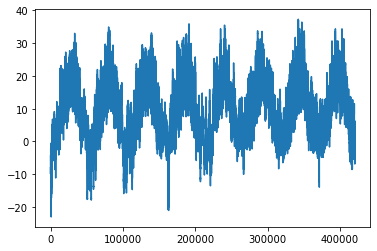

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()


An yearly periodicity of temperature can be observed.

In the cell below we plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

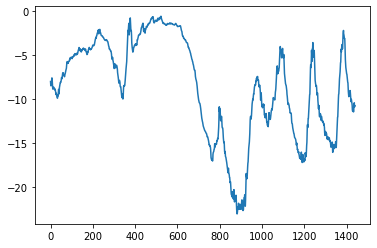

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()


A daily periodicity, especially evident for the last 4 days can be observed. We can also note that this ten-days period must be coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. An important quation to answer is if this timeseries predictable at a daily scale.

### Data Preparation

**Problem formulation:** given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days. (5d x 24h x 6 lookbacks/h or 720/6 =120 hours)
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

**Data normalization:** in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a similar scale.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first  200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

**Custom data generator**
We will write a Python generator that: </br>

    * takes our current array of float data 
    * yields batches of data from the recent past, alongside with a  target temperature in the future.

Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the fly using the original data.

The data generator yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. 

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    """Arguments:
    data : The original array of floating point data
    lookback : How many timesteps back should our input data go
    delay: How many timesteps in the future should our target be
    min_index: index in the `data` array that delimit which timesteps to draw from
    max_index: index in the `data` array that delimit which timesteps to draw from
    shuffle: Whether to shuffle our samples or draw them in chronological order.
    batch_size: The number of samples per batch.
    step: The period, in timesteps, at which we sample data; set  6 in order to draw one data point every hour
   
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### Define generators  for training, validation and testing

We will use the generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data:
* the training generator looks at the first 200,000 timesteps,
* the validation generator looks at the following 100,000
* the test generator looks at the remainder.

In [9]:
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### A first recurrent baseline


Instead of the `LSTM` layer introduced in the previous tutorial, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers (which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are less expensive to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

More exactely, we will use a GRU layer with 32 units and the output layer has only one neuron, because we predict a single real number.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [11]:
model = Sequential()
model.add(layers.GRU(units=32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [12]:
model.compile(optimizer=RMSprop(), loss='mae')

In [13]:
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3110 - val_loss: 0.2723
Epoch 2/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2855 - val_loss: 0.2655
Epoch 3/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2793 - val_loss: 0.2632
Epoch 4/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2738 - val_loss: 0.2634
Epoch 5/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2696 - val_loss: 0.2646
Epoch 6/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2661 - val_loss: 0.2623
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2627 - val_loss: 0.2664
Epoch 8/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2588 - val_loss: 0.2665
Epoch 9/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2539 - val_loss: 0.2698
Epoch 10/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2490 - val_lo

Vizualizing the training metrics

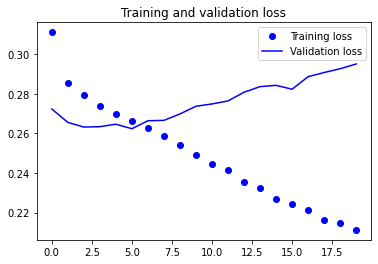

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging  considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in randomly zeroing-out input units of a layer in order to break random correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. Yarin Gal (2015) determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep.

Furhermore, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process.

**Every recurrent layer in Keras has two dropout-related arguments:**
* `dropout`, a float specifying the dropout rate for input units of the layer, and
* `recurrent_dropout`,  specifying the dropout rate of the recurrent units.

#### Task: 
Use the model we have traing previously with dropout and recurrent dropout to our GRU layer and see how it impacts overfitting.
Because networks being regularized with dropout always take longer to fully converge, please train the network for twice as many  epochs.

In [18]:
model = Sequential()
model.add(tf.keras.layers.GRU(units=32, input_shape=(None, float_data.shape[-1]), dropout=0.5, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                      steps_per_epoch=500,
                      epochs=2,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/2
500/500 [==============================] - 136s 273ms/step - loss: 0.3679 - val_loss: 0.3181
Epoch 2/2
500/500 [==============================] - 136s 272ms/step - loss: 0.3300 - val_loss: 0.2981


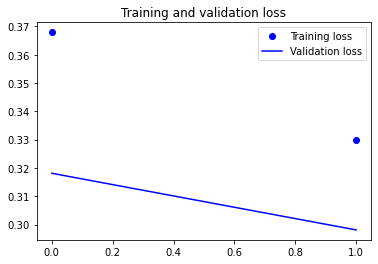

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

How did the dropout improved the training?

### Stacking recurrent layers

It is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks.

### Task:
Please increase the capacity of your model by adding an additional GRU layer with 64 units. Both recurrent layers should be regularized with Dropout techniques.

_HINT:_
To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying `return_sequences=True`.

In [ ]:
model = Sequential()
model.add(tf.keras.layers.GRU(units=32, input_shape=(None, float_data.shape[-1]), dropout=0.5, recurrent_dropout=0.3, return_sequences=True))
model.add(tf.keras.layers.GRU(units=64, input_shape=(None, float_data.shape[-1]), dropout=0.5, recurrent_dropout=0.3, return_sequences=True))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                      steps_per_epoch=500,
                      epochs=10,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 293s 586ms/step - loss: 0.4806 - val_loss: 0.4287
Epoch 2/10
500/500 [==============================] - 285s 569ms/step - loss: 0.4339 - val_loss: 0.4398
Epoch 3/10
500/500 [==============================] - 281s 562ms/step - loss: 0.4221 - val_loss: 0.4162
Epoch 4/10
500/500 [==============================] - 283s 566ms/step - loss: 0.4163 - val_loss: 0.4233
Epoch 5/10
500/500 [==============================] - 289s 578ms/step - loss: 0.4056 - val_loss: 0.4215
Epoch 6/10
500/500 [==============================] - 291s 582ms/step - loss: 0.3995 - val_loss: 0.4161
Epoch 7/10
500/500 [==============================] - 289s 578ms/step - loss: 0.3941 - val_loss: 0.4208
Epoch 8/10
500/500 [==============================] - 286s 572ms/step - loss: 0.3888 - val_loss: 0.4231
Epoch 9/10
500/500 [==============================] - 278s 557ms/step - loss: 0.3816 - val_loss: 0.4258
Epoch 10/10
498/500 [============================>.] - ETA: 0s -

Let's take a look at our results:

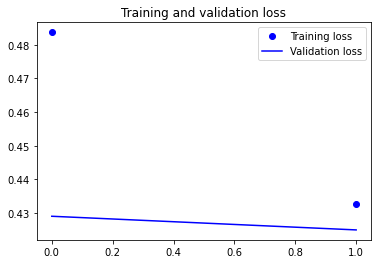

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();


### Improving your solution

There are still many other things you could try in order to improve performance on the weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing  architectures that are overfitting to the validation set.   


